# Set simulatin parameters, run simulation and save pickle file for all mc's of each model 


In [1]:
import numpy as np
import scipy as sp 
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import linear_model

import pickle
import os

In /Users/elynncc/anaconda3/envs/research/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/elynncc/anaconda3/envs/research/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/elynncc/anaconda3/envs/research/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/elynncc/anaconda3/envs/research/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases lat

In [2]:
# personal library

import MDP_CHAK10

import QLearning as QL
import TransferLinearModel as TLM
import TransferQLearning as TQL

In [3]:
horizon = 2
dim_tru = 8
r2_coef_0 = np.ones(dim_tru)
r2_coef_0[-1] = 0
r2_coef_1 = np.ones(dim_tru)
r2_coef_1[-1] = 0

diff = 0.2
r2_coef_1[1] += diff
#r2_coef_1[3] += diff # 'data_2/'


In [4]:
DATA_DIR = 'data/'
RES_DIR = 'res/'

In [5]:
p = 100

# n0 = 30
#n0_list = np.array([30], dtype=int)
#n1_list = np.array([40, 50, 60, 70, 80], dtype=int)

# n0 = 50
#n0_list = np.array([50], dtype=int)
#n1_list = np.array([60, 70, 80, 90, 100], dtype=int)

# n0 = 70
n0_list = np.array([70], dtype=int)
n1_list = np.array([80, 90, 100, 110, 120], dtype=int)

num_mc = 200

#settings = np.array([[n0, n1] for n0 in n0_list for n1 in (n0 * ra_list).astype(int) ])
settings = np.array([[p, n0, n1] 
                     for n0 in n0_list 
                     for n1 in n1_list])
# settings

In [6]:
def onemodel_sequential(r2_coef_0, r2_coef_1, horizon, dim_obs, 
                        num_obs_0, num_obs_1, num_mc, 
                        distn='n', noise_var = 1, 
                        _SEED = 6789):
    
    res_list = [None] * num_mc
    
    for ind_mc in np.arange(num_mc):
        seed = _SEED * (ind_mc + 1)
        res_list[ind_mc] = onemc(seed, ind_mc, r2_coef_0, r2_coef_1, 
                                 horizon, dim_obs, num_obs_0, num_obs_1,
                                 distn, noise_var=1)
    
    return(res_list)

In [7]:
def onemc(seed, ind_mc, r2_coef_0, r2_coef_1, 
          horizon, dim_obs, num_obs_0, num_obs_1,
          distn='n', noise_var = 1):
    
    np.random.seed(seed)
    
    mdp = MDP_CHAK10.MDP_CHAK10(dim_obs, noise_var)
    
    mdp.set_r2_coef(r2_coef_0)
    traj_0 = mdp.sample_random_obs(num_obs_0, distn)
    q_coef_0_tru = mdp.get_Q_coef()
    
    mdp.set_r2_coef(r2_coef_1)
    traj_1 = mdp.sample_random_obs(num_obs_1, distn)
    # q_coef_1_tru = mdp.get_Q_coef() 
    
    q_coef_0_sing = QL.Lasso(traj_0)
    
    q_coef_0_tran, _ = TQL.Lasso(traj_0, traj_1)
    
    return(np.hstack([q_coef_0_sing - q_coef_0_tru, 
                      q_coef_0_tran - q_coef_0_tru]))
    

In [8]:
for row, (dim_obs, num_obs_0, num_obs_1) in enumerate(settings):
    print('Processing model #' + str(row) +
          ' with (diff, p, n_0, n_1)=(' + str(diff) + ', ' + str(dim_obs) + ', ' + 
          str(num_obs_0) + ', ' + str(num_obs_1) + ').')
    distn = 'n'
    noise_var = 1
    res_list = onemodel_sequential(r2_coef_0, r2_coef_1, 
                                   horizon, dim_obs, 
                                   num_obs_0, num_obs_1, num_mc, 
                                   distn, noise_var, 
                                   _SEED = 6789)
    
    dump = 'diff-' + str(diff) + '-p-' + str(dim_obs) + '-n0-' + \
            str(num_obs_0) + '-n1-' + str(num_obs_1) + '-x-' + \
            distn + '-e-' + str(noise_var) + '-no-cv.pkl'
    pickle.dump(res_list, open(os.path.join(DATA_DIR, dump),'wb'))

Processing model #0 with (diff, p, n_0, n_1)=(0.2, 100, 70, 80).
Processing model #1 with (diff, p, n_0, n_1)=(0.2, 100, 70, 90).
Processing model #2 with (diff, p, n_0, n_1)=(0.2, 100, 70, 100).
Processing model #3 with (diff, p, n_0, n_1)=(0.2, 100, 70, 110).
Processing model #4 with (diff, p, n_0, n_1)=(0.2, 100, 70, 120).


# Load result file, combine and plot

In [9]:
for row, (dim_obs, num_obs_0, num_obs_1) in enumerate(settings):
    
    print('Processing model #' + str(row) +
          ' with (diff, p, n_0, n_1)=(' + str(diff) + ', ' + str(dim_obs) + ', ' + 
          str(num_obs_0) + ', ' + str(num_obs_1) + ').')
    
    dump = 'diff-' + str(diff) + '-p-' + str(dim_obs) + '-n0-' + \
            str(num_obs_0) + '-n1-' + str(num_obs_1) + '-x-' + \
            distn + '-e-' + str(noise_var) + '-no-cv.pkl'
    
    res_list = pickle.load(open(os.path.join(DATA_DIR, dump),'rb'))
    
    # res_array: num_mc * 4 x dim_obs
    res_array = np.hstack(res_list).transpose()
    
    if row == 0:
        all_res_array = res_array
    else:
        all_res_array = np.vstack([all_res_array, res_array])

Processing model #0 with (diff, p, n_0, n_1)=(0.2, 100, 70, 80).
Processing model #1 with (diff, p, n_0, n_1)=(0.2, 100, 70, 90).
Processing model #2 with (diff, p, n_0, n_1)=(0.2, 100, 70, 100).
Processing model #3 with (diff, p, n_0, n_1)=(0.2, 100, 70, 110).
Processing model #4 with (diff, p, n_0, n_1)=(0.2, 100, 70, 120).


In [10]:
simul = np.array([[n0, n1, i, trans, stage] 
                  for n0 in n0_list.astype(int)
                  for n1 in n1_list.astype(int)
                  for i in np.arange(num_mc)
                  for trans in [0, 1]
                  for stage in [0, 1]])

In [11]:
mse = np.apply_along_axis(sum, 1, all_res_array**2)

In [12]:
num_rows, _ = simul.shape
col_names = np.concatenate([['$n_0$', '$n_1$', 'mc', 'Trans', 'Stage', 'MSE'],
                         ['B' + str(p) for p in np.arange(dim_obs)] ])

In [13]:
all_res = pd.DataFrame(np.hstack([simul, mse[:,None], all_res_array]), columns=col_names)

In [14]:
all_res.head()

,$n_0$,$n_1$,mc,Trans,Stage,MSE,B0,B1,B2,B3,...,B90,B91,B92,B93,B94,B95,B96,B97,B98,B99
0,70.0,80.0,0.0,0.0,0.0,10.625643,-2.690399,-0.889428,-1.245266,-0.653536,...,0.0,0.560066,0.0,-0.0,0.0,0.000000,0.028567,0.034667,0.0,0.000000
1,70.0,80.0,0.0,0.0,1.0,1.798742,-1.000000,-0.285220,-0.431638,-0.131729,...,0.0,0.000000,-0.0,-0.0,0.0,-0.062826,-0.000000,0.000000,-0.0,0.000000
2,70.0,80.0,0.0,1.0,0.0,8.350042,-2.690399,-0.571136,-0.642770,-0.201647,...,0.0,0.167736,0.0,0.0,0.0,0.098931,0.000000,0.082666,0.0,0.042518
3,70.0,80.0,0.0,1.0,1.0,1.286114,-1.000000,-0.157476,-0.235520,-0.042646,...,0.0,0.000000,0.0,0.0,0.0,-0.075436,-0.000000,0.000000,0.0,0.000000
4,70.0,80.0,1.0,0.0,0.0,9.708066,-2.690399,-0.835151,-0.818884,-0.777768,...,0.0,0.000000,0.0,0.0,0.0,0.139397,0.105541,0.010471,0.0,0.000000


# Plot from DataFrame

In [15]:
import seaborn as sns

In [16]:
def combine(x):
    return '('+str(x[0])+', '+str(x[1])+')'

all_res['$(n_0, n_1)$'] = all_res[['$n_0$','$n_1$']].astype(int).apply(combine, 1)

In [17]:
df_s0 = all_res.loc[ all_res['Stage']==0, ['$(n_0, n_1)$', 'mc', 'Trans', 'Stage', 'MSE']]
df_s1 = all_res.loc[ all_res['Stage']==1, ['$(n_0, n_1)$', 'mc', 'Trans', 'Stage', 'MSE']]

In [18]:
df_s0.loc[df_s0['Trans']==0, 'Trans'] = 'No'
df_s0.loc[df_s0['Trans']==1, 'Trans'] = 'Yes'

df_s1.loc[df_s1['Trans']==0, 'Trans'] = 'No'
df_s1.loc[df_s1['Trans']==1, 'Trans'] = 'Yes'

In [19]:
fname = 'chakra-diff-' + str(diff) + '-p-' + str(dim_obs) + '-n0-' + \
        str(num_obs_0) + '-x-' + distn + '-e-' + str(noise_var)

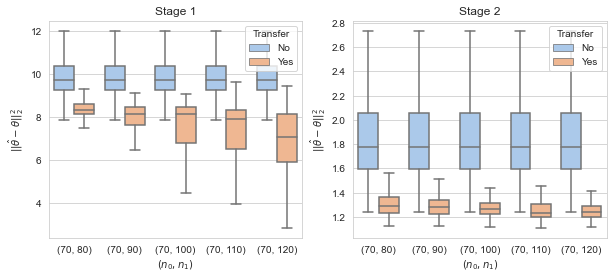

In [20]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(x='$(n_0, n_1)$', y='MSE', hue='Trans', data=df_s0, 
            palette="pastel", showfliers=False, ax=axes[0])

sns.boxplot(x='$(n_0, n_1)$', y='MSE', hue='Trans', data=df_s1, 
            palette="pastel", showfliers=False, ax=axes[1])

axes[0].set_ylabel("$||\\hat \\theta - \\theta||^2_2$")
axes[1].set_ylabel("$||\\hat \\theta - \\theta||^2_2$")

axes[0].set_title("Stage 1")
axes[1].set_title("Stage 2")

axes[0].legend(title="Transfer", loc="upper right")
axes[1].legend(title="Transfer", loc="upper right")

plt.savefig(os.path.join(RES_DIR, fname + '.pdf'), bbox_inches='tight')

In [21]:
#df = all_res.loc[ : , ['$(n_0, n_1)$', 'mc', 'Trans', 'Stage', 'MSE']]

In [22]:
#g = sns.FacetGrid(df, col="Stage")
#g.map(sns.boxplot, x="$(n_0, n_1)$", y="MSE", hue="Trans", data=df, palette="Set3")